<a href="https://colab.research.google.com/github/nurmaauliaazizah183/Project/blob/main/Project_Datmin_Revisi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
# !pip install --upgrade numpy==1.24.4
# !pip install --upgrade pmdarima

In [87]:
# !pip install statsmodels

### IMPORT & LOAD DATA

In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Load dataset
df = pd.read_csv("Superstore Dataset.csv")

# Lihat struktur awal data
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Order ID       9994 non-null   object 
 1   Order Date     9994 non-null   object 
 2   Ship Date      9994 non-null   object 
 3   Ship Mode      9994 non-null   object 
 4   Customer ID    9994 non-null   object 
 5   Customer Name  9994 non-null   object 
 6   Segment        9994 non-null   object 
 7   Country        9994 non-null   object 
 8   City           9994 non-null   object 
 9   State          9994 non-null   object 
 10  Postal Code    9994 non-null   int64  
 11  Region         9994 non-null   object 
 12  Product ID     9994 non-null   object 
 13  Category       9994 non-null   object 
 14  Sub-Category   9994 non-null   object 
 15  Product Name   9994 non-null   object 
 16  Sales          9994 non-null   float64
 17  Quantity       9994 non-null   int64  
 18  Discount

### PRE-PROCESSING

In [89]:
# Konversi kolom tanggal
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

# Urutkan berdasarkan tanggal pemesanan
df = df.sort_values(by='Order Date')

# Hapus baris dengan Ship Date < Order Date (tidak logis)
df = df[df['Ship Date'] >= df['Order Date']]

# Periksa kembali struktur data
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 9994 entries, 0 to 9993
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Order ID       9994 non-null   object        
 1   Order Date     9994 non-null   datetime64[ns]
 2   Ship Date      9994 non-null   datetime64[ns]
 3   Ship Mode      9994 non-null   object        
 4   Customer ID    9994 non-null   object        
 5   Customer Name  9994 non-null   object        
 6   Segment        9994 non-null   object        
 7   Country        9994 non-null   object        
 8   City           9994 non-null   object        
 9   State          9994 non-null   object        
 10  Postal Code    9994 non-null   int64         
 11  Region         9994 non-null   object        
 12  Product ID     9994 non-null   object        
 13  Category       9994 non-null   object        
 14  Sub-Category   9994 non-null   object        
 15  Product Name   9994 non-nu

In [90]:
# Cek missing value
print("Missing values per kolom:\n", df.isna().sum())

# Cek dan hapus duplikat
print("Jumlah duplikat:", df.duplicated().sum())
df = df.drop_duplicates()

# Interpolasi nilai numerik yang hilang
df.interpolate(method='linear', inplace=True)


Missing values per kolom:
 Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64
Jumlah duplikat: 1


In [91]:
# Hapus outlier menggunakan IQR untuk kolom numerik
numerical_cols = df.select_dtypes(include=np.number).columns

for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]


In [92]:
# Agregasi penjualan harian
df_daily = df.groupby('Order Date')['Sales'].sum().reset_index()

# Set indeks sebagai datetime dan pastikan frekuensi harian
df_daily = df_daily.set_index('Order Date').asfreq('D')

# Interpolasi nilai kosong untuk mengisi hari-hari tanpa transaksi
df_daily['Sales'] = df_daily['Sales'].interpolate(method='linear')

# Tampilkan beberapa data hasil agregasi
df_daily.head()


,Sales
Order Date,
2019-01-03,16.448000
2019-01-04,11.784000
2019-01-05,19.536000
2019-01-06,75.360000
2019-01-07,63.754667


In [93]:
# Uji stasioneritas ADF
adf_result = adfuller(df_daily['Sales'])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

# Differencing jika tidak stasioner
if adf_result[1] > 0.05:
    df_daily_diff = df_daily['Sales'].diff().dropna()
    print("Data tidak stasioner. Dilakukan differencing.")
else:
    df_daily_diff = df_daily['Sales']
    print("Data sudah stasioner.")


ADF Statistic: -4.727114699175964
p-value: 7.481779998724812e-05
Data sudah stasioner.


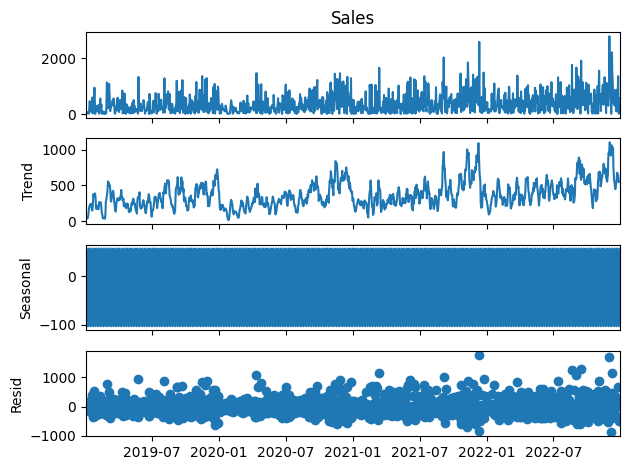

In [94]:
# Decompose tren dan musiman mingguan
decompose_result = seasonal_decompose(df_daily['Sales'], model='additive', period=7)
decompose_result.plot()
plt.tight_layout()
plt.show()


In [95]:
# Split data 80% train, 20% test
train_size = int(len(df_daily) * 0.8)
train = df_daily.iloc[:train_size]
test = df_daily.iloc[train_size:]

print("Train size:", train.shape)
print("Test size:", test.shape)


Train size: (1166, 1)
Test size: (292, 1)


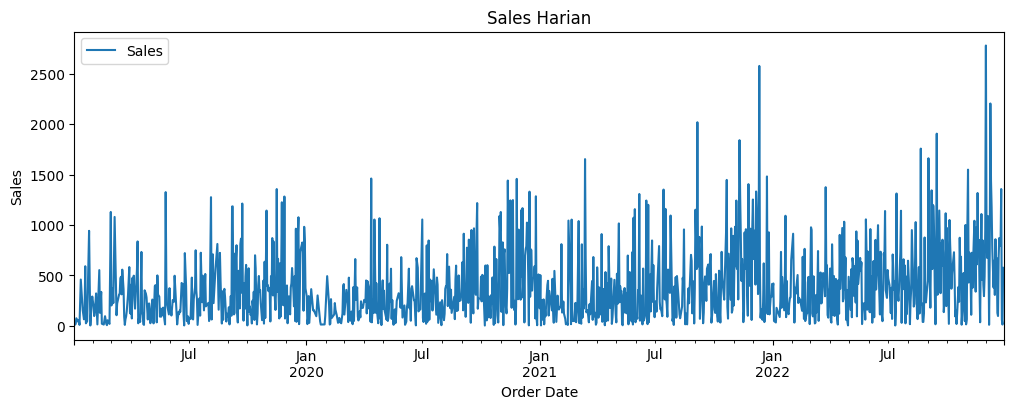

In [96]:
df_daily.plot(figsize=(12,4), title="Sales Harian")
plt.ylabel("Sales")
plt.show()


## EDA

### Distribusi Penjualan dan Profit

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sns.histplot(df['Sales'], kde=True)
plt.title("Distribusi Sales")

plt.subplot(1,2,2)
sns.histplot(df['Profit'], kde=True)
plt.title("Distribusi Profit")
plt.show()

### Total Sales per Category

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(data=df, x='Category', y='Sales', estimator='sum', errorbar=None)
plt.title("Total Sales per Category")
plt.xticks(rotation=45)
plt.show()

### Profit vs Discount

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='Discount', y='Profit', hue='Category')
plt.title("Profit vs Discount")
plt.show()

### Total Orders Over Time

In [ ]:
df_orders_per_day = df.groupby('Order Date')['Order ID'].nunique()
df_orders_per_day.plot(figsize=(12,5), title="Jumlah Order per Hari")
plt.ylabel("Jumlah Order")
plt.show()

### Heatmap Korelasi

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Korelasi antar Variabel Numerik")
plt.show()

### Segmentasi Penjualan berdasarkan Wilayah dan Segmen

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(data=df, x='Region', y='Sales', hue='Segment', estimator='sum', errorbar=None)
plt.title("Penjualan berdasarkan Wilayah dan Segmen")
plt.show()

## MODELLING

### SARIMA

In [122]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")


In [123]:
df_weekly = df_daily.resample('W').sum()
train_size = int(len(df_weekly) * 0.8)
train, test = df_weekly[:train_size], df_weekly[train_size:]


In [99]:
# train_diff = train.diff().dropna()


In [124]:
from pmdarima import auto_arima

# Menggunakan auto_arima untuk menemukan parameter terbaik
auto_model = auto_arima(train['Sales'], seasonal=True, m=52,
                         stepwise=True, trace=True,
                         error_action='ignore', suppress_warnings=True)

# Menampilkan ringkasan model
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=14.17 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=2847.801, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=2818.636, Time=1.12 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=2793.972, Time=4.77 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=2845.814, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=2801.912, Time=0.18 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=2794.460, Time=9.28 sec
 ARIMA(0,1,1)(0,0,2)[52] intercept   : AIC=2794.705, Time=26.91 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=2792.579, Time=4.45 sec
 ARIMA(0,1,1)(2,0,0)[52] intercept   : AIC=2794.476, Time=30.56 sec
 ARIMA(0,1,1)(2,0,1)[52] intercept   : AIC=inf, Time=61.54 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=2846.209, Time=1.97 sec
 ARIMA(1,1,1)(1,0,0)[52] intercept   : AIC=inf, Time=6.18 sec
 ARIMA(0,1,2)(1,0,0)[52] intercept   : AIC=inf, Time=9.72 sec
 ARIMA(1,1,2)(1,0,0)[52] intercept 

In [125]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train,
                order=(1,1,2),
                seasonal_order=(1,0,0,52),
                enforce_stationarity=False,
                enforce_invertibility=False)
result = model.fit()


In [126]:
forecast = result.predict(start=test.index[0], end=test.index[-1])


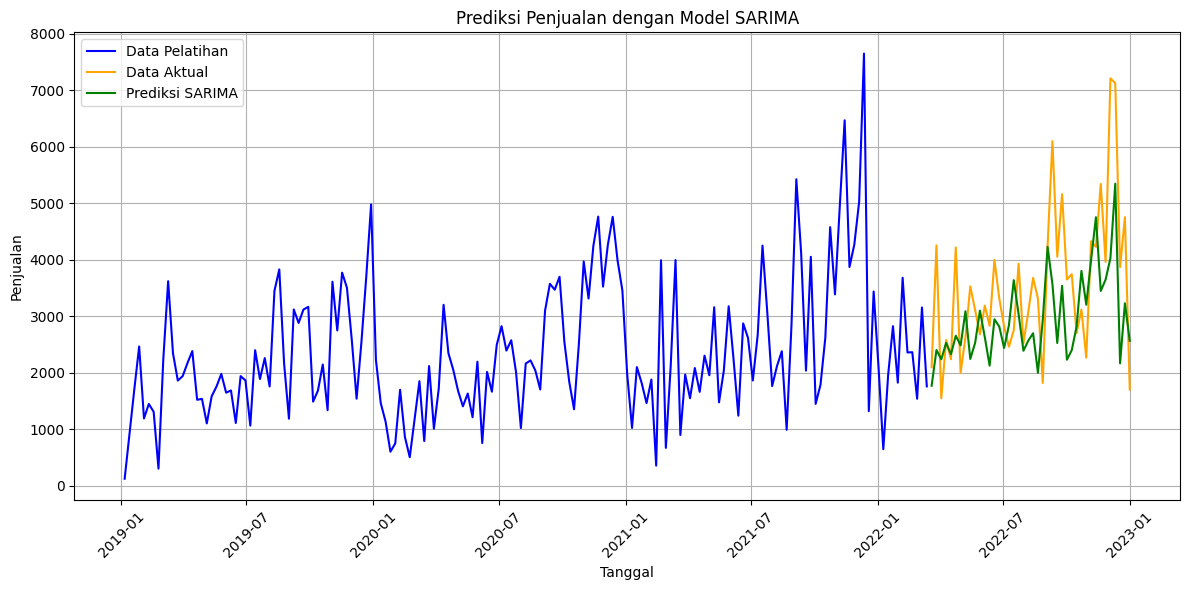

SARIMA RMSE: 1166.40
SARIMA MAPE: 25.93%


In [127]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

rmse = np.sqrt(mean_squared_error(test, forecast))
mape = mean_absolute_percentage_error(test, forecast) * 100

# Visualisasi hasil prediksi SARIMA
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Sales'], label='Data Pelatihan', color='blue')
plt.plot(test.index, test['Sales'], label='Data Aktual', color='orange')
plt.plot(test.index, forecast, label='Prediksi SARIMA', color='green')
plt.title('Prediksi Penjualan dengan Model SARIMA')
plt.xlabel('Tanggal')
plt.ylabel('Penjualan')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

print(f"SARIMA RMSE: {rmse:.2f}")
print(f"SARIMA MAPE: {mape:.2f}%")


### XGBOOST

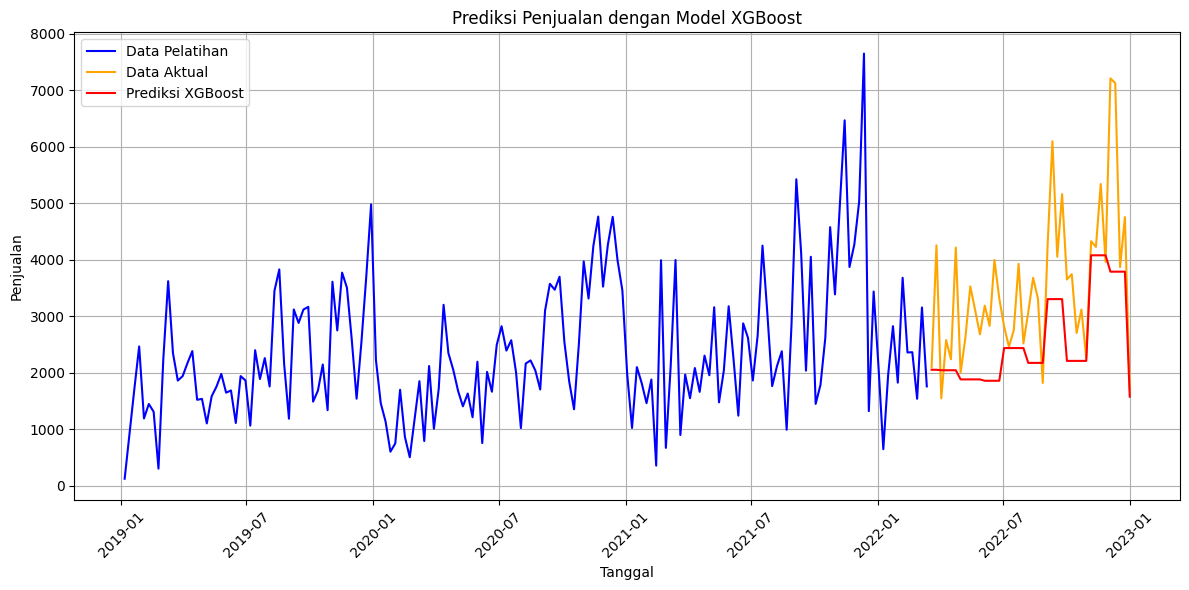

XGBoost RMSE: 1341.94
XGBoost MAPE: 26.08%


In [118]:
# Mengimpor pustaka yang diperlukan
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Menyiapkan data untuk XGBoost
# Menggunakan fitur yang sama dengan model SARIMA
train['Month'] = train.index.month
train['DayOfWeek'] = train.index.dayofweek
test['Month'] = test.index.month
test['DayOfWeek'] = test.index.dayofweek

# Memisahkan fitur dan target
X_train = train[['Month', 'DayOfWeek']]
y_train = train['Sales']
X_test = test[['Month', 'DayOfWeek']]
y_test = test['Sales']

# Membangun model XGBoost
xgboost_model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgboost_model.fit(X_train, y_train)

# Melakukan prediksi dengan XGBoost
xgboost_predictions = xgboost_model.predict(X_test)

# Menghitung metrik evaluasi untuk XGBoost
xgboost_rmse = np.sqrt(mean_squared_error(y_test, xgboost_predictions))
xgboost_mape = mean_absolute_percentage_error(y_test, xgboost_predictions) * 100

# Visualisasi hasil prediksi XGBoost
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Sales'], label='Data Pelatihan', color='blue')
plt.plot(test.index, test['Sales'], label='Data Aktual', color='orange')
plt.plot(test.index, xgboost_predictions, label='Prediksi XGBoost', color='red')
plt.title('Prediksi Penjualan dengan Model XGBoost')
plt.xlabel('Tanggal')
plt.ylabel('Penjualan')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

# Mencetak hasil evaluasi
print(f"XGBoost RMSE: {xgboost_rmse:.2f}")
print(f"XGBoost MAPE: {xgboost_mape:.2f}%")



### HOLT-WINTERS

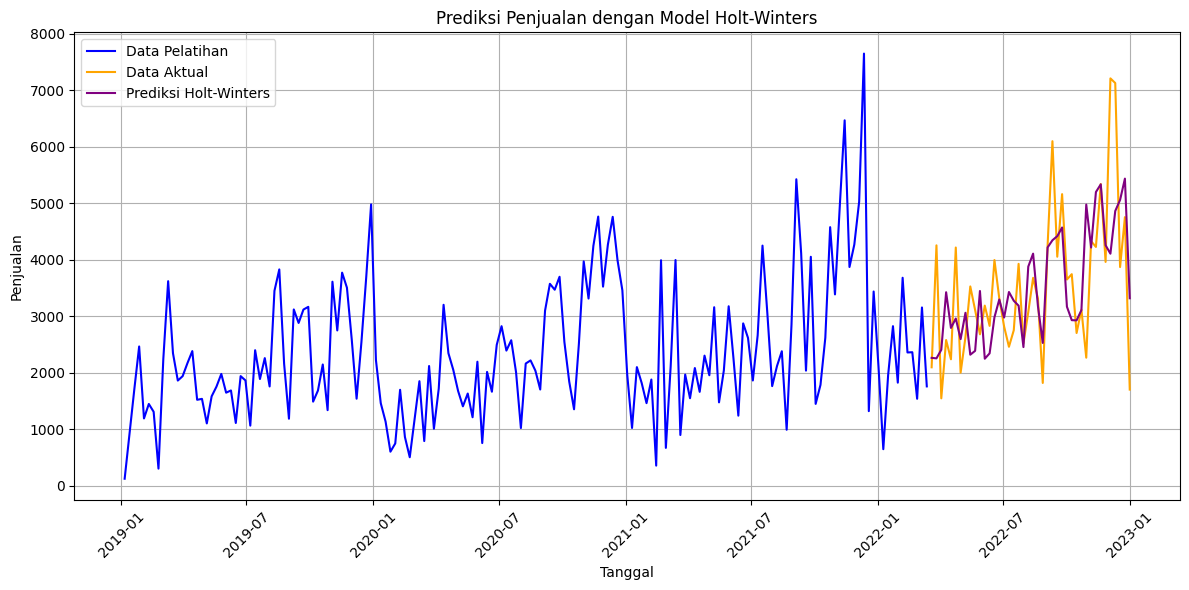

Holt-Winters RMSE: 1067.66
Holt-Winters MAPE: 24.53%


In [117]:
# Mengimpor pustaka yang diperlukan
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Membangun model Holt-Winters
holt_winters_model = ExponentialSmoothing(train['Sales'],
                                           trend='add',
                                           seasonal='add',
                                           seasonal_periods=52)  # 52 minggu untuk musiman tahunan
holt_winters_fit = holt_winters_model.fit()

# Melakukan prediksi dengan Holt-Winters
holt_winters_predictions = holt_winters_fit.forecast(len(test))

# Menghitung metrik evaluasi untuk Holt-Winters
holt_winters_rmse = np.sqrt(mean_squared_error(test['Sales'], holt_winters_predictions))
holt_winters_mape = mean_absolute_percentage_error(test['Sales'], holt_winters_predictions) * 100

# Visualisasi hasil prediksi Holt-Winters
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Sales'], label='Data Pelatihan', color='blue')
plt.plot(test.index, test['Sales'], label='Data Aktual', color='orange')
plt.plot(test.index, holt_winters_predictions, label='Prediksi Holt-Winters', color='purple')
plt.title('Prediksi Penjualan dengan Model Holt-Winters')
plt.xlabel('Tanggal')
plt.ylabel('Penjualan')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

# Mencetak hasil evaluasi
print(f"Holt-Winters RMSE: {holt_winters_rmse:.2f}")
print(f"Holt-Winters MAPE: {holt_winters_mape:.2f}%")
